In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pathlib 
import pandas as pd 
import os
import io
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

In [3]:
df = pd.read_csv('./spam.csv', encoding='ISO-8859-1')
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
df.groupby('v1').describe()

v2                                                                 \
     count unique                                                top freq   
v1                                                                          
ham   4825   4516                             Sorry, I'll call later   30   
spam   747    653  Please call our customer service representativ...    4   

     Unnamed: 2                                                            \
          count unique                                                top   
v1                                                                          
ham          45     39   bt not his girlfrnd... G o o d n i g h t . . .@"   
spam          5      4                                        PO Box 5249   

          Unnamed: 3                                    Unnamed: 4         \
     freq      count unique                    top freq      count unique   
v1                                                                          
ham     3         10      9                     GE    2          6      5   
spam    2          2      1   MK17 92H. 450Ppw 16"    2          0      0   

                    
          top freq  
v1                  
ham   GNT:-)"    2  
spam      NaN  NaN

In [5]:
df['length']=df['v2'].apply(len)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,length
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61


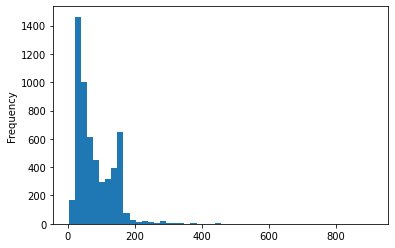

In [6]:
df['length'].plot(bins=50, kind='hist')

In [7]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

In [8]:
df = df.rename(columns={'v1':'label','v2':'message'})

In [9]:
import re

df['message_clean'] = df['message'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower())

In [10]:
!python -m spacy download en_core_web_sm

2023-01-02 01:02:34.030557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-02 01:02:34.030677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-02 01:02:34.030700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.0 MB/s 
✔ Downloa

In [11]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [12]:
from spacy.lang.fr.stop_words import STOP_WORDS

In [13]:
for token in nlp(df['message_clean'][0]) : 
  print(token.lemma_) 

go
until
jurong
point
crazy
available
only
in
bugis
n
great
world
la
e
buffet
cine
there
get
amore
wat


In [14]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(df.message_clean)
df["message_enc"] = tokenizer.texts_to_sequences(df.message_clean)
df["category"] = df["label"].apply(lambda x: 1 if x=="spam" else 0)
df.head()

,label,message,length,message_clean,message_enc,category
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,"[47, 442, 1, 797, 712, 679, 65, 10, 1, 91, 121...",0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,"[49, 312, 1, 443, 7, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...,"[51, 459, 10, 23, 5, 750, 903, 2, 181, 1, 1, 6...",1
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,"[7, 231, 144, 25, 354, 1, 7, 161, 145, 61, 144]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i dont think he goes to usf he lives aroun...,"[954, 3, 46, 98, 73, 460, 2, 904, 73, 1, 204, ...",0


In [15]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(df.message_enc, padding="post")

In [16]:
xtrain, xval, ytrain, yval = train_test_split(message_pad,df.category, test_size=0.2)

In [17]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [18]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [19]:
for sms, categ in train_batch.take(1):
  print(sms, categ)

tf.Tensor(
[[ 84  20 601 ...   0   0   0]
 [536  17   1 ...   0   0   0]
 [ 25  55 112 ...   0   0   0]
 ...
 [ 41 155   9 ...   0   0   0]
 [243 231 235 ...   0   0   0]
 [  1 291 284 ...   0   0   0]], shape=(64, 171), dtype=int32) tf.Tensor(
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0], shape=(64,), dtype=int64)


In [20]:
sms.shape[1]

171

In [36]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[sms.shape[1]],name="embedding"),
                  # Gobal max pooling
                  tf.keras.layers.GlobalMaxPooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
                  tf.keras.layers.Dense(1, activation="sigmoid")
                            ])

In [37]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy
              ()])

In [38]:
history = model.fit(train_batch, epochs=50, validation_data=val_batch)

Epoch 1/50
70/70 [==============================] - 12s 146ms/step - loss: 0.6450 - binary_accuracy: 0.7882 - val_loss: 0.5775 - val_binary_accuracy: 0.8780
Epoch 2/50
70/70 [==============================] - 3s 44ms/step - loss: 0.5087 - binary_accuracy: 0.8629 - val_loss: 0.4206 - val_binary_accuracy: 0.8780
Epoch 3/50
70/70 [==============================] - 2s 25ms/step - loss: 0.3969 - binary_accuracy: 0.8629 - val_loss: 0.3419 - val_binary_accuracy: 0.8780
Epoch 4/50
70/70 [==============================] - 2s 31ms/step - loss: 0.3398 - binary_accuracy: 0.8629 - val_loss: 0.2848 - val_binary_accuracy: 0.8780
Epoch 5/50
70/70 [==============================] - 2s 24ms/step - loss: 0.2728 - binary_accuracy: 0.8768 - val_loss: 0.2161 - val_binary_accuracy: 0.9193
Epoch 6/50
70/70 [==============================] - 1s 18ms/step - loss: 0.2042 - binary_accuracy: 0.9168 - val_loss: 0.1608 - val_binary_accuracy: 0.9480
Epoch 7/50
70/70 [==============================] - 1s 10ms/step - l

In [29]:
from plotly import graph_objects as go

color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]


fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [30]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[4]
                          )),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[5]
                          ))
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy'    
)
fig.show()

In [33]:
# Use the model to predict whether a message is spam
messages_received = ['Greg, can you call me back once you get this?',
                'Congrats on your new iPhone! Click here to claim your prize...', 
                'Really like that new photo of you',
                'Did you hear the news today? Terrible what has happened...',
                'Attend this free COVID webinar today: Book your session now...']

print(messages_received) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(messages_received)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=171)           

fakes_prediction = model.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(messages_received)):
  print(messages_received[x])
  print(fakes_prediction[x])
  print('\n')

['Greg, can you call me back once you get this?', 'Congrats on your new iPhone! Click here to claim your prize...', 'Really like that new photo of you', 'Did you hear the news today? Terrible what has happened...', 'Attend this free COVID webinar today: Book your session now...']
1/1 [==============================] - 0s 52ms/step
Greg, can you call me back once you get this?
[7.0171984e-05]


Congrats on your new iPhone! Click here to claim your prize...
[0.99475646]


Really like that new photo of you
[0.00162714]


Did you hear the news today? Terrible what has happened...
[3.8623293e-05]


Attend this free COVID webinar today: Book your session now...
[0.9739188]




In [39]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.4 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 439 kB 67.8 MB/s 
     |████████████████████████████████| 6.0 MB 52.1 MB/s 
     |████████████████████████████████| 1.7 MB 54.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [23]:
import tensorflow_text

text_test = [df.message_clean[5]]

preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
text_preprocessed = bert_preprocessor(text_test)

In [24]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
model_tlbert = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [26]:
model_tlbert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [27]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model_tlbert.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [31]:
# Train test split per text 
text_train, text_test, y_train, y_test = train_test_split(df.message_clean, df.category, test_size=0.1, random_state=1,stratify=df.category)

text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.1, random_state=1,stratify=y_train)

# creating tensorflow datasets slices and making batches

text_train_ds = tf.data.Dataset.from_tensor_slices((text_train, y_train))
text_test_ds = tf.data.Dataset.from_tensor_slices((text_test, y_test))
text_val_ds = tf.data.Dataset.from_tensor_slices((text_val, y_val))

text_train_ds = text_train_ds.shuffle(len(text_train_ds)).batch(64)
text_test_ds = text_test_ds.shuffle(len(text_test_ds)).batch(64)
text_val_ds = text_val_ds.shuffle(len(text_val_ds)).batch(64)

In [32]:
history_tlbert = model_tlbert.fit(text_train_ds, epochs=50, validation_data=text_val_ds)

Epoch 1/50
71/71 [==============================] - 66s 788ms/step - loss: 0.3615 - accuracy: 0.8659 - precision: 0.5000 - recall: 0.0017 - val_loss: 0.2984 - val_accuracy: 0.8645 - val_precision: 0.3333 - val_recall: 0.0149
Epoch 2/50
71/71 [==============================] - 56s 788ms/step - loss: 0.2812 - accuracy: 0.8759 - precision: 0.8082 - recall: 0.0975 - val_loss: 0.2437 - val_accuracy: 0.8825 - val_precision: 0.7500 - val_recall: 0.1791
Epoch 3/50
71/71 [==============================] - 55s 770ms/step - loss: 0.2362 - accuracy: 0.8956 - precision: 0.8602 - recall: 0.2645 - val_loss: 0.2150 - val_accuracy: 0.9223 - val_precision: 0.8333 - val_recall: 0.5224
Epoch 4/50
71/71 [==============================] - 55s 777ms/step - loss: 0.2090 - accuracy: 0.9162 - precision: 0.8771 - recall: 0.4364 - val_loss: 0.1899 - val_accuracy: 0.9283 - val_precision: 0.8605 - val_recall: 0.5522
Epoch 5/50
71/71 [==============================] - 54s 767ms/step - loss: 0.1872 - accuracy: 0.9258

In [33]:
def performance_model(model, X, y):

    y_pred = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
  
    model_performance = {'accuracy': accuracy,
                          'f1-score': f1}
  
    return model_performance

In [39]:
Basic_model = performance_model(model,xval, yval)
BERT_model = performance_model(model_tlbert,text_val, y_val)
  
data_results = pd.DataFrame({'Sequential Simple Model':Basic_model,
                              'BERT-Transfer learning Model':BERT_model}).transpose()
                             
data_results.iloc[:,:3]

16/16 [==============================] - 5s 324ms/step


,accuracy,f1-score
Sequential Simple Model,0.973094,0.892086
BERT-Transfer learning Model,0.986056,0.947368
